In [1]:
cd ../src

/home/richard/Desktop/software/epicluster-results_upload/epicluster-results/src


In [2]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import copy
import scipy.stats
import branchpro
import epicluster as ec

In [3]:
random.seed(123)
np.random.seed(123)

In [4]:
all_results = []
kappas = [100, 10, 1, 0.5]

for kappa in kappas:

    # serial interval
    serial_interval = pd.read_csv("../data/raw/covid_serial_interval.csv")
    w = serial_interval['w']
    w = w[:20]
    w = w / sum(w)

    # data
    data = pd.read_csv("../data/synthetic/negbin_{}.csv".format(kappa))
    Rt_series = np.asarray(data['Rt'])
    cases = np.asarray(data['cases'])

    past_cases = np.zeros(len(w))
    past_cases[-1] = 5
    past_cases[-2] = 5
    past_cases[-3] = 5

    inf_cases = np.concatenate([past_cases, cases])


    # run branchpro
    a = 1
    b = 5

    inc_data = pd.DataFrame(
        {
            'Time': np.arange(len(inf_cases)),
            'Incidence Number': inf_cases
        }
    )

    inference = branchpro.BranchProPosterior(
        inc_data=inc_data,
        daily_serial_interval=w,
        alpha=a,
        beta=1/b)

    inference.run_inference(tau=7)
    intervals7 = inference.get_intervals(central_prob=.9)

    inference.run_inference(tau=28)
    intervals28 = inference.get_intervals(central_prob=.9)

    # run change point
    p = ec.PoissonModel(copy.deepcopy(inf_cases), w, prior_expected_clusters=1.5)
    mcmc = ec.MCMCSampler(p, 2)
    phi_chain, z_chain, counts = mcmc.run_mcmc(Rhat_thresh=1.05, progress=True)

    # load epifilter
    epi_results = pd.read_csv('../data/synthetic/results/nb/nb_{}.csv'.format(kappa))

    # save results
    results_synth = cases, Rt_series, w, phi_chain, z_chain, intervals7, intervals28, epi_results
    all_results.append(results_synth)

Iter=50, Rhat=36.04743745465078
Iter=100, Rhat=12.05912979561334
Iter=150, Rhat=6.4756328556364675
Iter=200, Rhat=4.104310125513124
Iter=250, Rhat=2.447722782136937
Iter=300, Rhat=1.7931621433625453
Iter=350, Rhat=1.3606479495421693
Iter=400, Rhat=1.1018146877980681
Iter=450, Rhat=1.0770563167445686
Iter=500, Rhat=1.109709301690525
Iter=550, Rhat=1.143222325131217
Iter=600, Rhat=1.10449339031571
Iter=650, Rhat=1.0793114456497774
Iter=700, Rhat=1.1163525743968492
Iter=750, Rhat=1.0477116879057575
Converged 750 1.0477116879057575
Iter=50, Rhat=33.3132446454176
Iter=100, Rhat=23.218886960516894
Iter=150, Rhat=16.848338018228894
Iter=200, Rhat=12.189201571484126
Iter=250, Rhat=11.455873180932583
Iter=300, Rhat=8.792748526304948
Iter=350, Rhat=9.551177917236085
Iter=400, Rhat=13.840852484120889
Iter=450, Rhat=8.498695376946873
Iter=500, Rhat=7.560590803855912
Iter=550, Rhat=8.215830426949454
Iter=600, Rhat=8.052384233431408
Iter=650, Rhat=7.211719178853044
Iter=700, Rhat=7.391642193497915
I

Iter=1300, Rhat=1.4633159734158188
Iter=1350, Rhat=1.42650035942783
Iter=1400, Rhat=1.3838650271636381
Iter=1450, Rhat=1.3699305565464266
Iter=1500, Rhat=1.4316656767999658
Iter=1550, Rhat=1.448478959139469
Iter=1600, Rhat=1.4818668921154177
Iter=1650, Rhat=1.4132652887684845
Iter=1700, Rhat=1.3930028365064595
Iter=1750, Rhat=1.3972367928246494
Iter=1800, Rhat=1.398244910234157
Iter=1850, Rhat=1.3469518612226778
Iter=1900, Rhat=1.3312918666001574
Iter=1950, Rhat=1.3368290203838036
Iter=2000, Rhat=1.3511433767096475
Iter=2050, Rhat=1.41650555435417
Iter=2100, Rhat=1.4444039836462015
Iter=2150, Rhat=1.4506165932158166
Iter=2200, Rhat=1.4563846373508926
Iter=2250, Rhat=1.3995772743466057
Iter=2300, Rhat=1.3700525009720963
Iter=2350, Rhat=1.361667480878802
Iter=2400, Rhat=1.4062201769731357
Iter=2450, Rhat=1.4419631942480824
Iter=2500, Rhat=1.4566058750860742
Iter=2550, Rhat=1.4666852736532714
Iter=2600, Rhat=1.4492153897711666
Iter=2650, Rhat=1.4386151703647712
Iter=2700, Rhat=1.433013768

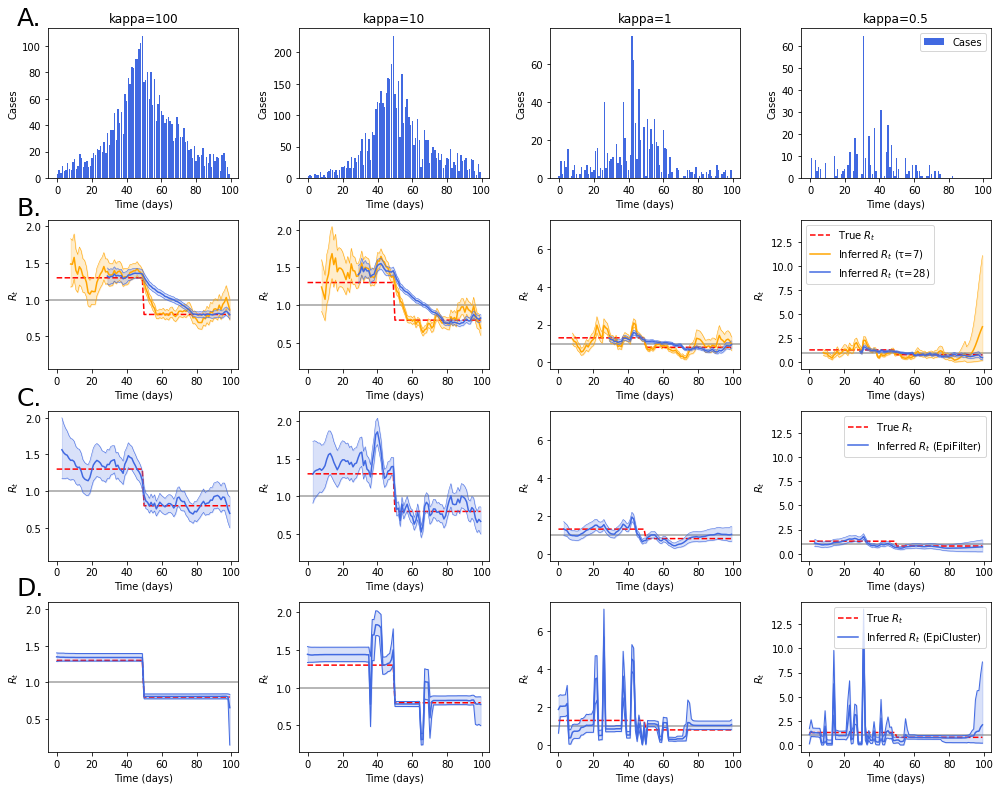

In [5]:
fig = plt.figure(figsize=(14,11))

num_exps = 4

for i in range(num_exps):
    
    do_legend = i==num_exps-1

    cases, Rt_series, w, phi_chain, z_chain, intervals7, intervals28, epi_results = all_results[i]
    title = 'kappa={}'.format(kappas[i])

        
    ax = fig.add_subplot(4, num_exps, 1+i)

    x = np.arange(len(cases))
    ax.bar(x, cases, label='Cases', color='royalblue')
    ax.set_title(title)

    if do_legend:
        ax.legend()
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Cases')

    ax = fig.add_subplot(4, num_exps, 3*num_exps+i+1)
    Rs = []
    num_mcmc = len(z_chain)
    for phi, z in zip(phi_chain[num_mcmc//4:], z_chain[num_mcmc//4:]):
        Rs.append([phi[zi] for zi in z])
    ax.plot(x, Rt_series, color='red', label='True $R_t$', ls='--')
    ax.plot(x, np.mean(Rs, axis=0), color='royalblue', label='Inferred $R_t$ (EpiCluster)')
    ax.fill_between(x, np.percentile(Rs, 5, axis=0), np.percentile(Rs, 95, axis=0), color='royalblue', alpha=0.2)
    ax.plot(x, np.percentile(Rs, 5, axis=0), color='royalblue', lw=1)
    ax.plot(x, np.percentile(Rs, 95, axis=0), color='royalblue', lw=1)
    
    ax.axhline(1, color='gray', alpha=0.75, zorder=-10)
    
    if do_legend:
        ax.legend(loc='upper right')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('$R_t$')

    ax = fig.add_subplot(4, num_exps, num_exps+i+1, sharey=ax)
    x = np.arange(len(w), len(cases))
    x = np.arange(len(cases))
    ax.plot(x, Rt_series, color='red', label='True $R_t$', ls='--')

    x = np.arange(8, len(cases))
    ax.plot(x, intervals7['Mean'][len(w):], color='orange', label='Inferred $R_t$ (τ=7)')
    ax.fill_between(x, intervals7['Lower bound CI'][len(w):], intervals7['Upper bound CI'][len(w):], alpha=0.2, color='orange')
    ax.plot(x, intervals7['Lower bound CI'][len(w):], color='orange', lw=0.5)
    ax.plot(x, intervals7['Upper bound CI'][len(w):], color='orange', lw=0.5)
    
    x = np.arange(29, len(cases))
    ax.plot(x, intervals28['Mean'][len(w):], color='royalblue', label='Inferred $R_t$ (τ=28)')
    ax.fill_between(x, intervals28['Lower bound CI'][len(w):], intervals28['Upper bound CI'][len(w):], alpha=0.2, color='royalblue')
    ax.plot(x, intervals28['Lower bound CI'][len(w):], color='royalblue', lw=0.5)
    ax.plot(x, intervals28['Upper bound CI'][len(w):], color='royalblue', lw=0.5)
    
    ax.axhline(1, color='gray', alpha=0.75, zorder=-10)
    
    if do_legend:
        ax.legend()
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('$R_t$')
    
    
    
    ax = fig.add_subplot(4, num_exps, 2*num_exps+i+1, sharey=ax)
    
    x = np.arange(len(w), len(cases))
    x = np.arange(len(cases))
    ax.plot(x, Rt_series, color='red', label='True $R_t$', ls='--')


    x = epi_results['day'][1:]
    mean = epi_results['R_smooth'][1:]
    lb = epi_results['R_smooth_lower_bound'][1:]
    ub = epi_results['R_smooth_upper_bound'][1:]
    ax.plot(x, mean, color='royalblue', label='Inferred $R_t$ (EpiFilter)')
    ax.fill_between(x, lb, ub, alpha=0.2, color='royalblue')
    ax.plot(x, lb, color='royalblue', lw=0.5)
    ax.plot(x, ub, color='royalblue', lw=0.5)  
    
    ax.axhline(1, color='gray', alpha=0.75, zorder=-10)

    if do_legend:
        ax.legend()
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('$R_t$')
    

fig.set_tight_layout(True)

plt.subplots_adjust(left=0.2)
fig.text(.02, .97, 'A.', fontsize=25)
fig.text(.02, .73, 'B.', fontsize=25)
fig.text(.02, .49, 'C.', fontsize=25)
fig.text(.02, .25, 'D.', fontsize=25)

plt.savefig('../notebooks/FigureS5.pdf')
plt.show()
